# Tabular modelling deep dive

In [ ]:
from fastai2.tabular.all import *
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
dls = TabularDataLoaders.from_df(ratings, procs=Categorify, 
    cat_names=['user', 'movie'], cont_names=[], y_names='rating')
dls.show_batch()

,user,movie,rating
0,363,328,3
1,668,323,4
2,708,457,4
3,457,378,4
4,440,515,4
5,385,122,3
6,864,234,4
7,301,43,5
8,699,15,1
9,197,770,3


## Categorical embeddings

## Beyond deep learning

## The dataset

### Kaggle Competitions

In [ ]:
creds = ''

In [ ]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

In [ ]:
path = URLs.path('bluebook')
path

Path('/home/alexis/.fastai/archive/bluebook')

In [ ]:
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('Machine_Appendix.csv'),Path('TrainAndValid.csv'),Path('median_benchmark.csv'),Path('Valid.csv'),Path('random_forest_benchmark_test.csv'),Path('ValidSolution.csv'),Path('Test.csv')]

### Look at the data

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [ ]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [ ]:
dep_var = 'SalePrice'

In [ ]:
df[dep_var] = np.log(df[dep_var])

## Decision trees

### Handling dates

In [ ]:
df = add_datepart(df, 'saledate')

In [ ]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Using TabularPandas and TabularProc

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train),len(to.valid)

(404710, 7988)

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,SalesID_na,MachineID_na,ModelID_na,datasource_na,auctioneerID_na,YearMade_na,MachineHoursCurrentMeter_na,saleYear_na,saleMonth_na,saleWeek_na,saleDay_na,saleDayofweek_na,saleDayofyear_na,saleElapsed_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1163635200,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1080259200,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1077753600,9.210340


In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleDay_na,saleDayofweek_na,saleDayofyear_na,saleElapsed_na
0,1139246,11.097410,999089,3157,...,1,1,1,1
1,1139248,10.950807,117657,77,...,1,1,1,1
2,1139249,9.210340,434808,7009,...,1,1,1,1


In [ ]:
to.classes['ProductSize']

(#7) ['#na#','Large','Large / Medium','Medium','Small','Mini','Compact']

In [ ]:
(path/'to.pkl').save(to)

### Creating the decision tree

In [ ]:
to = (path/'to.pkl').load()

In [ ]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

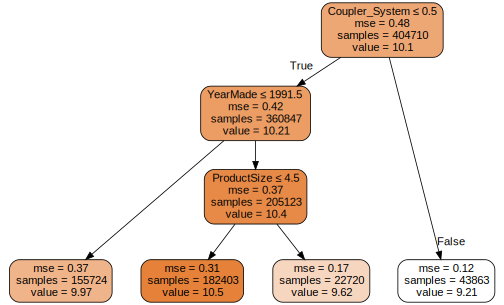

In [ ]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

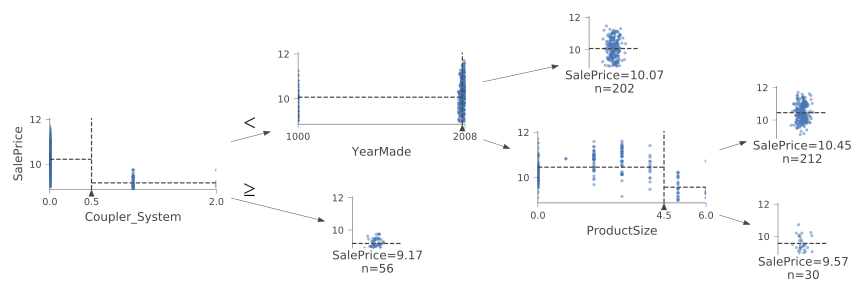

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

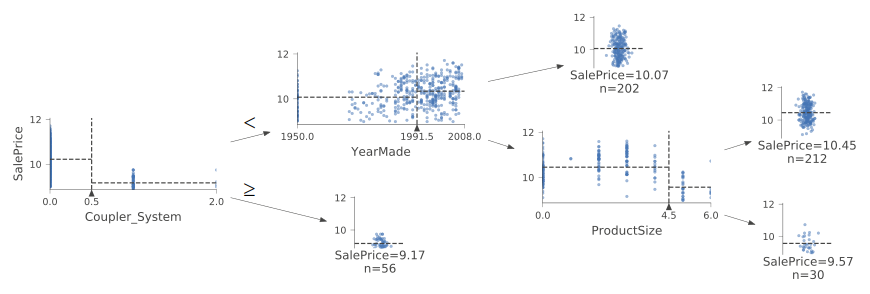

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [ ]:
def rmse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return rmse(m.predict(xs), y)

In [ ]:
m_rmse(m, xs, y)

1e-06

In [ ]:
m_rmse(m, valid_xs, valid_y)

0.333364

In [ ]:
m.get_n_leaves(), len(xs)

(324556, 404710)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.32368)

In [ ]:
m.get_n_leaves()

12397

### Categorical variables

## Random forests

### Introduction

### Creating a random forest

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

In [ ]:
%time m = rf(xs, y, max_samples=None, min_samples_leaf=3, n_estimators=160);

CPU times: user 10min 23s, sys: 2.12 s, total: 10min 26s
Wall time: 1min 4s


In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.116937, 0.227631)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
rmse(preds.mean(0), valid_y)

0.227631

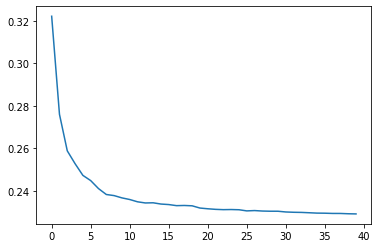

In [ ]:
plt.plot([rmse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-bag error

In [ ]:
rmse(m.oob_prediction_, y)

0.199995

## Model interpretation

### Tree variance for prediction confidence

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(160, 7988)

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([0.28327426, 0.13398439, 0.11037557, 0.30096074, 0.14296232])

### Feature importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
69,YearMade,0.174123
30,Coupler_System,0.118094
6,ProductSize,0.114451
7,fiProductClassDesc,0.075237
66,ModelID,0.060036
77,saleElapsed,0.052516
32,Hydraulics_Flow,0.042795
3,fiSecondaryDesc,0.042648
31,Grouser_Tracks,0.035323
1,fiModelDesc,0.032692


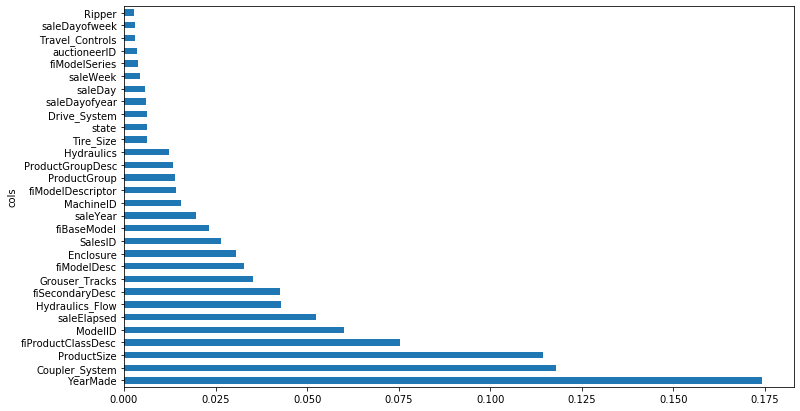

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing low-importance variables

In [ ]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

24

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.174417, 0.233386)

In [ ]:
len(xs.columns), len(xs_imp.columns)

(78, 24)

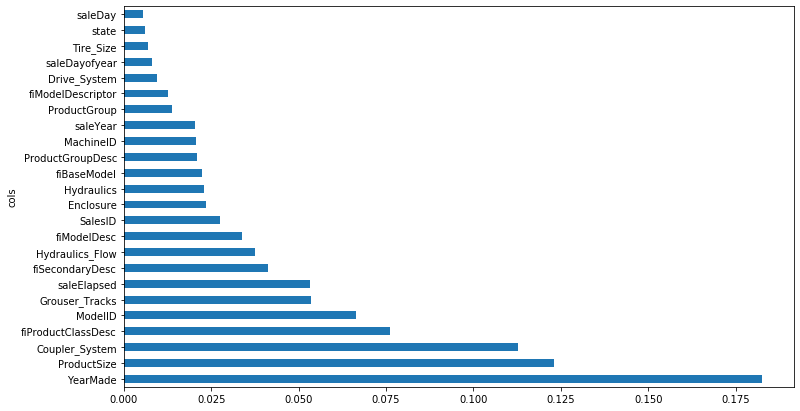

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing redundant features

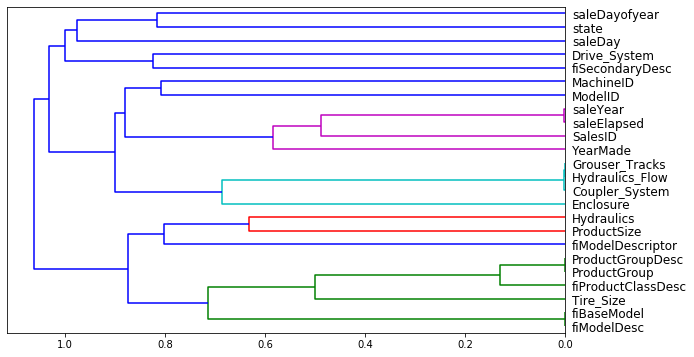

In [ ]:
cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

0.8771473509722694

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8746595337764449,
 'saleElapsed': 0.8725473016416591,
 'ProductGroupDesc': 0.8765077285271327,
 'ProductGroup': 0.8768477212252583,
 'fiModelDesc': 0.8750842799518633,
 'fiBaseModel': 0.8761482719270625,
 'Hydraulics_Flow': 0.877593996509983,
 'Grouser_Tracks': 0.8770436672268761,
 'Coupler_System': 0.8765826980928161}

In [ ]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8751690720764055

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [ ]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [ ]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

In [ ]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.175367, 0.234662)

### Partial dependence

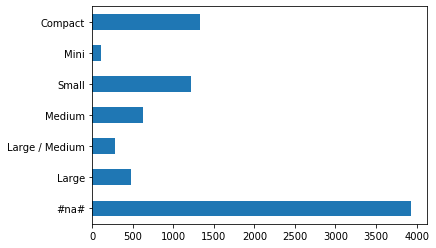

In [ ]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

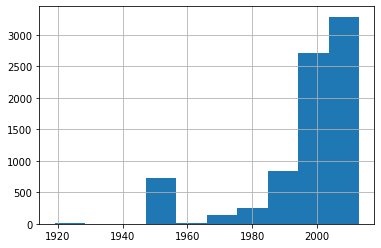

In [ ]:
ax = valid_xs_final['YearMade'].hist()

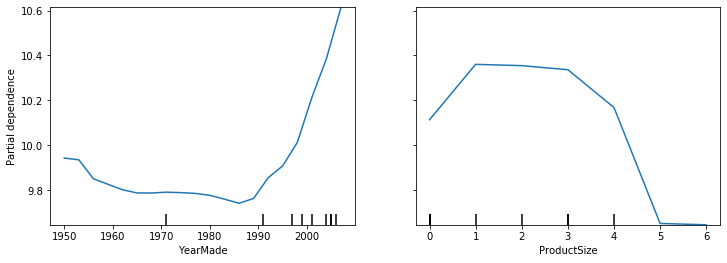

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Data leakage

### Tree interpreter

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([9.98606641]), 10.104604905444452, -0.11853849596071668)

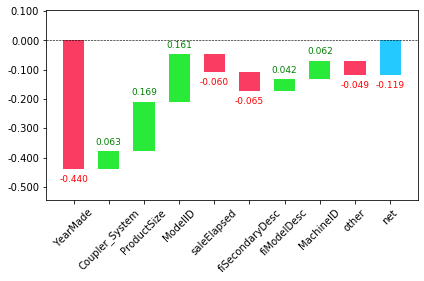

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

### The extrapolation problem

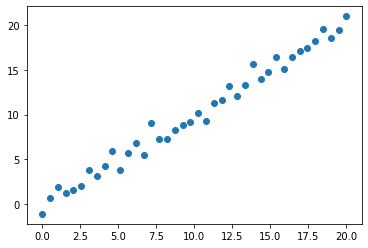

In [ ]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [ ]:
x_lin[:,None].shape

torch.Size([40, 1])

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

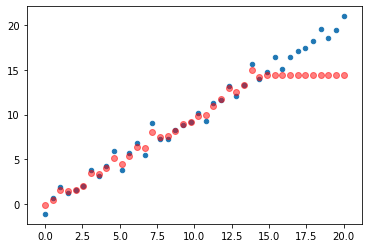

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

### Finding out of domain data

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.549273
18,saleDayofyear,0.319218
10,SalesID,0.087736
11,MachineID,0.029138
19,saleDay,0.008471
16,state,0.004985


In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.236195
SalesID 0.234278
saleElapsed 0.24077
MachineID 0.23531


In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.234519

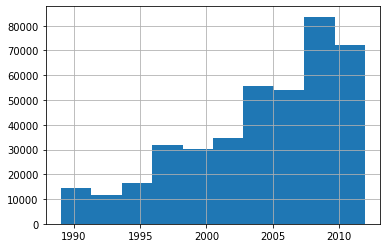

In [ ]:
xs['saleYear'].hist();

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.159735, 0.232199)

### Using a neural network

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [ ]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
Hydraulics_Flow          3
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Tire_Size               17
state                   53
Drive_System             4
saleDayofyear          361
saleDay                 31
dtype: int64

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m = rf(xs_filt2, y_filt)
m_rmse(m, xs_filt2, y_filt), m_rmse(m, valid_xs_time2, valid_y)

(0.160902, 0.23367)

In [ ]:
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(8.465899897028686, 11.863582336583399)

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250])

(0.002754228748381138, 0.00019054606673307717)

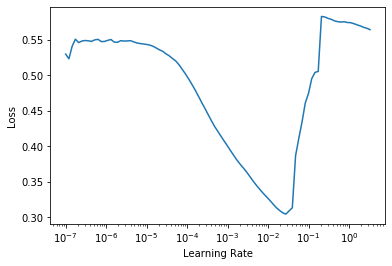

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.065677,0.065729,00:10
1,0.052406,0.070518,00:10
2,0.045449,0.054078,00:10
3,0.038349,0.055017,00:10
4,0.033643,0.054870,00:10


In [ ]:
preds,targs = learn.get_preds()
rmse(preds,targs)

0.234243

In [ ]:
learn.save('nn')

### Ensembling

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
rmse(ens_preds,valid_y)

### Boosting

## Combining embeddings with other methods

## Our advice for tabular modeling